In [4]:

from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D
from keras.models import Sequential,Model
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import Imageimage_generator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools 
import datetime
import cv2
import os
import io

In [5]:
labels = ['glioma', 'meningioma', 'no_tumor', 'pituitary']
testing_path = 'Testing/'
training_path = 'Training/'
image_size = 200

In [6]:
def augment_image_file(file):
    image = cv2.imread(file, 0) 
    image = cv2.bilateralFilter(image, 2, 50, 50)
    image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
    image = cv2.resize(image, (image_size, image_size))
    return image

In [7]:
def load_data(path, labels):
    X, y = [], []
    for label in labels:
        label_path = os.path.join(path, label)
        for file in os.listdir(label_path):
            image = augment_image_file(os.path.join(label_path, file))
            X.append(image)
            y.append(labels.index(label))
    return np.array(X) / 255.0, y

X_train, y_train = load_data(training_path, labels)
X_test, y_test = load_data(testing_path, labels)


In [8]:
X_train, y_train = shuffle(X_train, y_train, random_state=42)

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42) # 20% of the data is validation data

In [9]:
image_gen = Imageimage_generator(
    rotation_range=10,                        
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)

image_gen.fit(X_train)

In [10]:
resnet = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(image_size, image_size, 3)
)

2023-10-11 14:35:18.210679: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-10-11 14:35:18.211157: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-10-11 14:35:18.211161: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-10-11 14:35:18.212461: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-11 14:35:18.212933: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
model = resnet.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.4)(model)
model = Dense(4, activation='softmax')(model)
model = Model(inputs=resnet.input, outputs=model)

adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy', 'AUC'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 206, 206, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 100, 100, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 100, 100, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [18]:
class_names = list(labels)

def plot_to_image(figure):    
    buffer = io.BytesIO()
    plt.savefig(buffer, format='png')
    plt.close(figure)
    buffer.seek(0)

    digit = tf.image.decode_png(buffer.getvalue(), channels=4)
    digit = tf.expand_dims(digit, 0)

    return digit

def plot_confusion_matrix(cm, class_names): 
    figure = plt.figure(figsize=(8, 8)) 
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent) 
    plt.title("Confusion matrix") 
    plt.colorbar() 
    tick_marks = np.arange(len(class_names)) 
    plt.xticks(tick_marks, class_names, rotation=45) 
    plt.yticks(tick_marks, class_names)

    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)  
    threshold = cm.max() / 2. 

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):   
        color = "white" if cm[i, j] > threshold else "black"   
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)  
    
    plt.tight_layout() 
    plt.ylabel('True label') 
    plt.xlabel('Predicted label') 

    return figure

def display_conf_matrix(epoch, logs):
    predictions = np.argmax(model.predict(X_test), axis=1)
    cm = confusion_matrix(np.argmax(y_test,axis=1), predictions)
    figure = plot_confusion_matrix(cm, class_names=class_names)
    cm_image = plot_to_image(figure)

In [19]:
BATCH_SIZE = 64
EPOCHS = 30

checkpoint = ModelCheckpoint(filepath='model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, mode='min', restore_best_weights=True, verbose=1)

scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=1, mode='min')

callbacks = [
    early_stopping, 
    scheduler, 
    checkpoint, 
    LambdaCallback(on_epoch_end=display_conf_matrix)
]

history = model.fit(
    image_gen.flow(
        X_train, y_train, batch_size=20
    ),
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/30
511/511 [==============================] - ETA: 0s - loss: 0.1015 - accuracy: 0.9666 - auc: 0.9972
Epoch 1: val_loss improved from inf to 0.16574, saving model to model-01-0.96-0.17.h5


/Users/adisveletanlic/git/brain-tumor-classifier/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


511/511 [==============================] - 178s 334ms/step - loss: 0.1015 - accuracy: 0.9666 - auc: 0.9972 - val_loss: 0.1657 - val_accuracy: 0.9569 - val_auc: 0.9930 - lr: 1.0000e-04
Epoch 2/30
511/511 [==============================] - ETA: 0s - loss: 0.0703 - accuracy: 0.9759 - auc: 0.9986
Epoch 2: val_loss improved from 0.16574 to 0.09582, saving model to model-02-0.97-0.10.h5


/Users/adisveletanlic/git/brain-tumor-classifier/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


511/511 [==============================] - 163s 319ms/step - loss: 0.0703 - accuracy: 0.9759 - auc: 0.9986 - val_loss: 0.0958 - val_accuracy: 0.9695 - val_auc: 0.9972 - lr: 1.0000e-04
Epoch 3/30
511/511 [==============================] - ETA: 0s - loss: 0.0580 - accuracy: 0.9812 - auc: 0.9988
Epoch 3: val_loss did not improve from 0.09582
511/511 [==============================] - 163s 319ms/step - loss: 0.0580 - accuracy: 0.9812 - auc: 0.9988 - val_loss: 0.0969 - val_accuracy: 0.9718 - val_auc: 0.9969 - lr: 1.0000e-04
Epoch 4/30
511/511 [==============================] - ETA: 0s - loss: 0.0527 - accuracy: 0.9813 - auc: 0.9990
Epoch 4: val_loss improved from 0.09582 to 0.08254, saving model to model-04-0.98-0.08.h5


/Users/adisveletanlic/git/brain-tumor-classifier/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


511/511 [==============================] - 163s 319ms/step - loss: 0.0527 - accuracy: 0.9813 - auc: 0.9990 - val_loss: 0.0825 - val_accuracy: 0.9757 - val_auc: 0.9974 - lr: 1.0000e-04
Epoch 5/30
511/511 [==============================] - ETA: 0s - loss: 0.0525 - accuracy: 0.9838 - auc: 0.9991
Epoch 5: val_loss improved from 0.08254 to 0.07552, saving model to model-05-0.98-0.08.h5


/Users/adisveletanlic/git/brain-tumor-classifier/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


511/511 [==============================] - 168s 329ms/step - loss: 0.0525 - accuracy: 0.9838 - auc: 0.9991 - val_loss: 0.0755 - val_accuracy: 0.9781 - val_auc: 0.9978 - lr: 1.0000e-04
Epoch 6/30
511/511 [==============================] - ETA: 0s - loss: 0.0492 - accuracy: 0.9831 - auc: 0.9990
Epoch 6: val_loss did not improve from 0.07552
511/511 [==============================] - 171s 333ms/step - loss: 0.0492 - accuracy: 0.9831 - auc: 0.9990 - val_loss: 0.1946 - val_accuracy: 0.9428 - val_auc: 0.9914 - lr: 1.0000e-04
Epoch 7/30
511/511 [==============================] - ETA: 0s - loss: 0.0386 - accuracy: 0.9876 - auc: 0.9990
Epoch 7: val_loss did not improve from 0.07552
511/511 [==============================] - 160s 312ms/step - loss: 0.0386 - accuracy: 0.9876 - auc: 0.9990 - val_loss: 0.0845 - val_accuracy: 0.9745 - val_auc: 0.9975 - lr: 1.0000e-04
Epoch 8/30
511/511 [==============================] - ETA: 0s - loss: 0.0369 - accuracy: 0.9880 - auc: 0.9993
Epoch 8: val_loss did no

/Users/adisveletanlic/git/brain-tumor-classifier/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


511/511 [==============================] - 163s 318ms/step - loss: 0.0248 - accuracy: 0.9920 - auc: 0.9996 - val_loss: 0.0734 - val_accuracy: 0.9742 - val_auc: 0.9981 - lr: 1.0000e-04
Epoch 11/30
511/511 [==============================] - ETA: 0s - loss: 0.0360 - accuracy: 0.9871 - auc: 0.9994
Epoch 11: val_loss did not improve from 0.07341
511/511 [==============================] - 161s 315ms/step - loss: 0.0360 - accuracy: 0.9871 - auc: 0.9994 - val_loss: 0.1378 - val_accuracy: 0.9640 - val_auc: 0.9945 - lr: 1.0000e-04
Epoch 12/30
511/511 [==============================] - ETA: 0s - loss: 0.0284 - accuracy: 0.9916 - auc: 0.9995
Epoch 12: val_loss improved from 0.07341 to 0.06774, saving model to model-12-0.98-0.07.h5


/Users/adisveletanlic/git/brain-tumor-classifier/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


511/511 [==============================] - 162s 316ms/step - loss: 0.0284 - accuracy: 0.9916 - auc: 0.9995 - val_loss: 0.0677 - val_accuracy: 0.9820 - val_auc: 0.9983 - lr: 1.0000e-04
Epoch 13/30
511/511 [==============================] - ETA: 0s - loss: 0.0310 - accuracy: 0.9894 - auc: 0.9996
Epoch 13: val_loss did not improve from 0.06774
511/511 [==============================] - 161s 314ms/step - loss: 0.0310 - accuracy: 0.9894 - auc: 0.9996 - val_loss: 0.1582 - val_accuracy: 0.9542 - val_auc: 0.9932 - lr: 1.0000e-04
Epoch 14/30
511/511 [==============================] - ETA: 0s - loss: 0.0253 - accuracy: 0.9917 - auc: 0.9996
Epoch 14: val_loss did not improve from 0.06774
511/511 [==============================] - 161s 315ms/step - loss: 0.0253 - accuracy: 0.9917 - auc: 0.9996 - val_loss: 0.1716 - val_accuracy: 0.9538 - val_auc: 0.9926 - lr: 1.0000e-04
Epoch 15/30
511/511 [==============================] - ETA: 0s - loss: 0.0361 - accuracy: 0.9886 - auc: 0.9994
Epoch 15: val_loss 

/Users/adisveletanlic/git/brain-tumor-classifier/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


511/511 [==============================] - 169s 330ms/step - loss: 0.0169 - accuracy: 0.9947 - auc: 0.9998 - val_loss: 0.0604 - val_accuracy: 0.9816 - val_auc: 0.9978 - lr: 1.0000e-04
Epoch 17/30
511/511 [==============================] - ETA: 0s - loss: 0.0270 - accuracy: 0.9926 - auc: 0.9994
Epoch 17: val_loss did not improve from 0.06038
511/511 [==============================] - 156s 305ms/step - loss: 0.0270 - accuracy: 0.9926 - auc: 0.9994 - val_loss: 0.1331 - val_accuracy: 0.9628 - val_auc: 0.9940 - lr: 1.0000e-04
Epoch 18/30
511/511 [==============================] - ETA: 0s - loss: 0.0256 - accuracy: 0.9916 - auc: 0.9996
Epoch 18: val_loss did not improve from 0.06038
511/511 [==============================] - 154s 301ms/step - loss: 0.0256 - accuracy: 0.9916 - auc: 0.9996 - val_loss: 0.0718 - val_accuracy: 0.9796 - val_auc: 0.9976 - lr: 1.0000e-04
Epoch 19/30
511/511 [==============================] - ETA: 0s - loss: 0.0199 - accuracy: 0.9940 - auc: 0.9996
Epoch 19: val_loss 

/Users/adisveletanlic/git/brain-tumor-classifier/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


511/511 [==============================] - 155s 303ms/step - loss: 0.0199 - accuracy: 0.9940 - auc: 0.9996 - val_loss: 0.0574 - val_accuracy: 0.9859 - val_auc: 0.9972 - lr: 1.0000e-04
Epoch 20/30
511/511 [==============================] - ETA: 0s - loss: 0.0221 - accuracy: 0.9921 - auc: 0.9997
Epoch 20: val_loss did not improve from 0.05741
511/511 [==============================] - 155s 302ms/step - loss: 0.0221 - accuracy: 0.9921 - auc: 0.9997 - val_loss: 0.0617 - val_accuracy: 0.9871 - val_auc: 0.9969 - lr: 1.0000e-04
Epoch 21/30
511/511 [==============================] - ETA: 0s - loss: 0.0151 - accuracy: 0.9946 - auc: 1.0000
Epoch 21: val_loss did not improve from 0.05741
511/511 [==============================] - 154s 301ms/step - loss: 0.0151 - accuracy: 0.9946 - auc: 1.0000 - val_loss: 0.0984 - val_accuracy: 0.9745 - val_auc: 0.9956 - lr: 1.0000e-04
Epoch 22/30
511/511 [==============================] - ETA: 0s - loss: 0.0272 - accuracy: 0.9924 - auc: 0.9995
Epoch 22: val_loss 

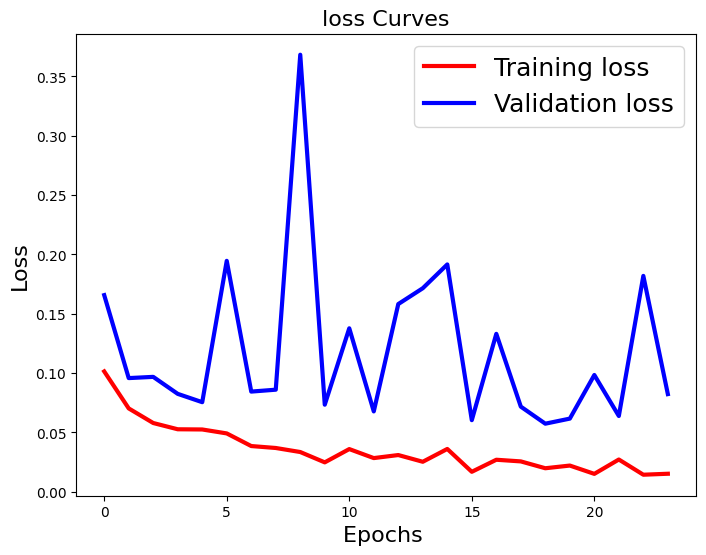

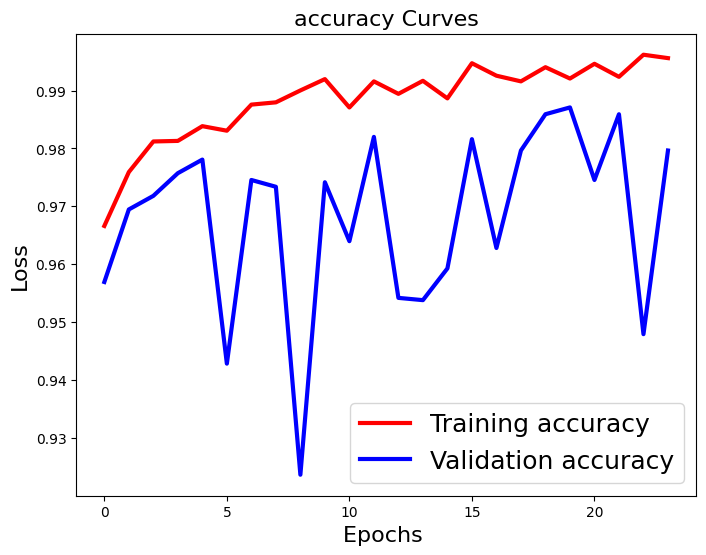

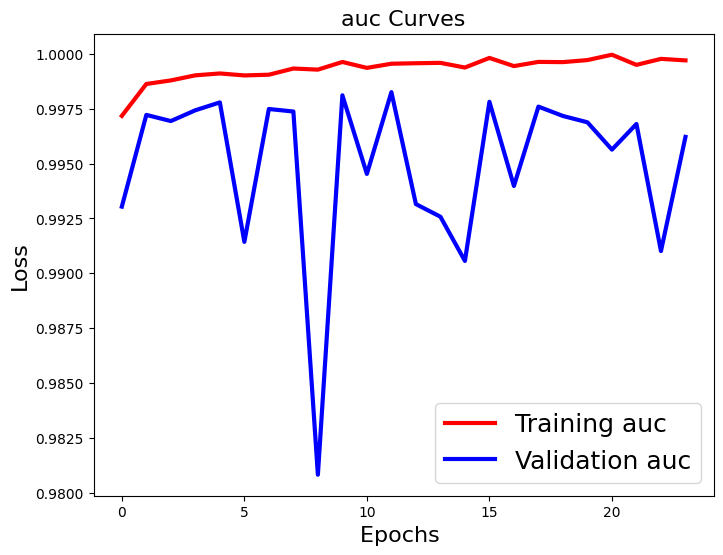

In [21]:
def plot(metric):
    plt.figure(figsize=[8,6])
    plt.plot(history.history[metric], 'r', linewidth=3.0)
    plt.plot(history.history[f'val_{metric}'], 'b', linewidth=3.0)
    plt.legend([f'Training {metric}', f'Validation {metric}'], fontsize=18)
    plt.xlabel('Epochs ', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.title(f'{metric} Curves', fontsize=16)
    plt.show()
    
plot('loss')
plot('accuracy')
plot('auc')

54/54 [==============================] - 7s 140ms/step
              precision    recall  f1-score   support

           0       0.98      0.89      0.93       399
           1       0.94      1.00      0.97       421
           2       0.95      0.99      0.97       510
           3       1.00      0.97      0.99       374

    accuracy                           0.96      1704
   macro avg       0.97      0.96      0.96      1704
weighted avg       0.96      0.96      0.96      1704



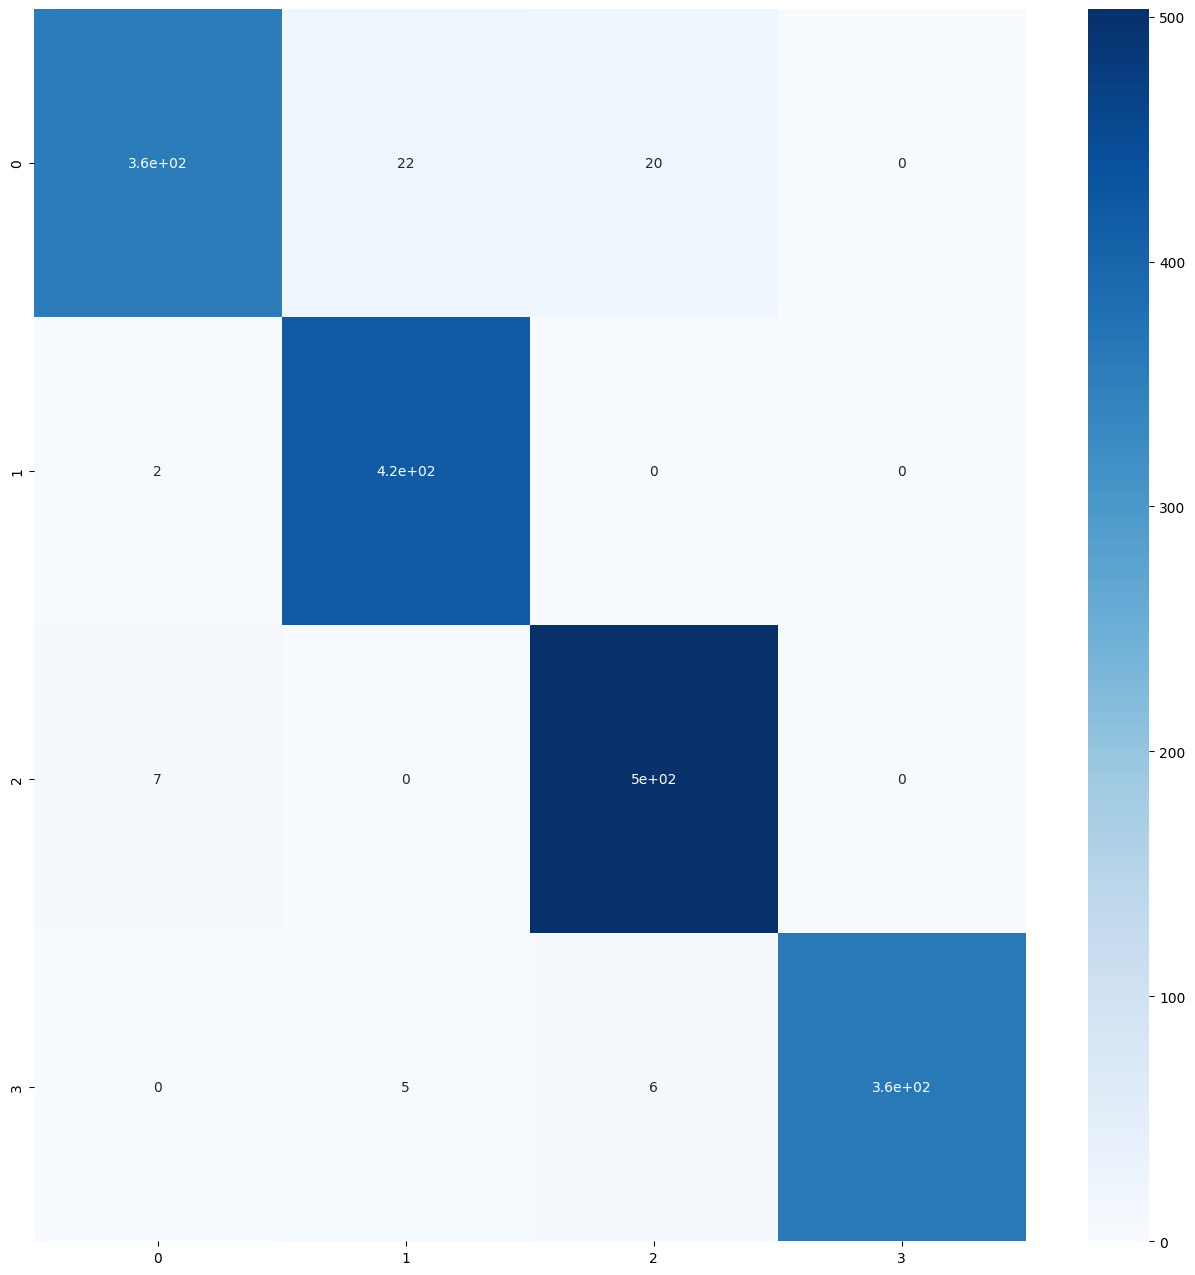

In [22]:
predicted_classes = np.argmax(model.predict(X_test), axis=1)
confusionmatrix = confusion_matrix(np.argmax(y_test,axis=1), predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap='Blues', annot=True, cbar=True)
print(classification_report(np.argmax(y_test,axis=1), predicted_classes))

In [24]:
loss, acc, auc = model.evaluate(X_test, y_test)

54/54 [==============================] - 6s 116ms/step - loss: 0.1908 - accuracy: 0.9636 - auc: 0.9921
